## Predicting presence of chronice kidner disease
### Notebook contains scripts for training Neural networks for predicting presence of Kideny Disease

Note: The notebook imports the processed data

In [34]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns


In [35]:
df_encoded = pd.read_csv("encoded_data_KD.csv")

# separate features and labels
x = df_encoded.drop(['Unnamed: 0', 'classification'], axis=1)
x = x.drop(['id'], axis=1)
y = df_encoded['classification']

x.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,hemo,pcv,wc,rc,htn,dm,cad,appet,pe,ane
0,40,3,3,1,0,1,1,0,0,48,...,90,30,69,33,1,2,0,0,0,0
1,5,0,3,4,0,1,1,0,0,26,...,49,24,53,33,0,1,0,0,0,0
2,54,3,1,2,3,1,1,0,0,140,...,32,17,67,33,0,2,0,1,0,1
3,40,2,0,4,0,1,0,1,0,44,...,48,18,59,18,1,1,0,1,1,1
4,43,3,1,2,0,1,1,0,0,33,...,52,21,65,26,0,1,0,0,0,0


In [36]:
# find label distribution
from collections import Counter
print(Counter(y))

Counter({0: 250, 1: 150})


In [37]:
from imblearn.over_sampling import RandomOverSampler

ros= RandomOverSampler()

x_ros, y_ros = ros.fit_resample(x,y)
print(Counter(y_ros))

Counter({0: 250, 1: 250})


In [38]:
# Scaling the numerical values using the MinMaxScaler

scaler = MinMaxScaler((-1,1))
x = scaler.fit_transform(x_ros)
y = y_ros

In [39]:
# Dimensionality Reduction using PCA

from sklearn.decomposition import PCA

pca = PCA(0.95)
x_decomposed = pca.fit_transform(x)

print(x.shape)
print(x_decomposed.shape)

(500, 24)
(500, 18)


In [54]:
# Splitting data to test and train
from sklearn.model_selection import train_test_split

x_train,x_test,y_train, y_test = train_test_split(x_decomposed,y,test_size=0.2,random_state=7)

In [55]:
# building model
import keras
from  keras.models import Sequential
from keras.layers import Dense, Dropout

from keras.callbacks import ModelCheckpoint, EarlyStopping

from keras.optimizers import Adam
from sklearn.model_selection import KFold

def model()-> Sequential:
    classifier = Sequential()
    classifier.add(Dense(15, input_shape= (x_train.shape[1],), activation='relu' )) # type: ignore
    classifier.add(Dropout(0.2))
    classifier.add(Dense(15, activation= 'relu'))
    classifier.add(Dropout(0.4))
    classifier.add(Dense(1, activation='sigmoid'))

    classifier.compile(optimizer='adam', loss= 'binary_crossentropy', metrics=['accuracy'])
    return classifier


model = model() # type: ignore
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 15)                285       
                                                                 
 dropout_8 (Dropout)         (None, 15)                0         
                                                                 
 dense_13 (Dense)            (None, 15)                240       
                                                                 
 dropout_9 (Dropout)         (None, 15)                0         
                                                                 
 dense_14 (Dense)            (None, 1)                 16        
                                                                 
Total params: 541
Trainable params: 541
Non-trainable params: 0
_________________________________________________________________


In [56]:
history = model.fit(x_train, y_train, validation_data = (x_test,y_test), epochs=5, verbose=1)

Epoch 1/5
13/13 [==============================] - 1s 28ms/step - loss: 0.6874 - accuracy: 0.4700 - val_loss: 0.6430 - val_accuracy: 0.4900
Epoch 2/5
13/13 [==============================] - 0s 6ms/step - loss: 0.6428 - accuracy: 0.5500 - val_loss: 0.6089 - val_accuracy: 0.7400
Epoch 3/5
13/13 [==============================] - 0s 6ms/step - loss: 0.5853 - accuracy: 0.6875 - val_loss: 0.5751 - val_accuracy: 0.8800
Epoch 4/5
13/13 [==============================] - 0s 6ms/step - loss: 0.5398 - accuracy: 0.7675 - val_loss: 0.5421 - val_accuracy: 0.9100
Epoch 5/5
13/13 [==============================] - 0s 6ms/step - loss: 0.5309 - accuracy: 0.7800 - val_loss: 0.5094 - val_accuracy: 0.9500


In [57]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import precision_recall_curve, average_precision_score, f1_score
from  sklearn.metrics import precision_recall_curve
#plotting roc
def plot_roc(t_y, p_y):
    fpr, tpr, thresholds = roc_curve(t_y, p_y, pos_label=1)
    fig,ax = plt.subplots(1,1,figsize=(9,9))
    ax.plot(fpr, tpr, label='%s (AUC:%0.2f)' %('classificaiton', auc(fpr,tpr)))
    ax.plot([0,1],[0,1], color='navy', lw=1, linestyle='--')
    ax.legend()
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')

# plot precision - recall curve
def plot_precision_recall_curve_helper(t_y,p_y):
    fig, ax = plt.subplots(1,1, figsize=(9,9))
    precision, recall, thresholds = precision_recall_curve(t_y,p_y,pos_label=1)
    aps = average_precision_score(t_y, p_y)
    ax.plot(recall, precision,label='Classification (AP Scode: %0.2f)' %(aps))
    ax.plot(recall,precision, color='blue', lw=2)
    ax.legend()
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')

def plot_history(history):
    f = plt.figure()
    f.set_figwidth(15)

    f.add_subplot(1,2,1)
    plt.plot(history.history['val_loss'], label='val loss')
    plt.plot(history.history['loss'], label= 'train loss')
    plt.legend()
    plt.title('Model Loss')

    f.add_subplot(1,2,2)
    plt.plot(history.history['val_accuracy'], label='val accuracy')
    plt.plot(history.history['accuracy'], label= 'train accuracy')
    plt.legend()
    plt.title('Model Accuracy')

    plt.show()


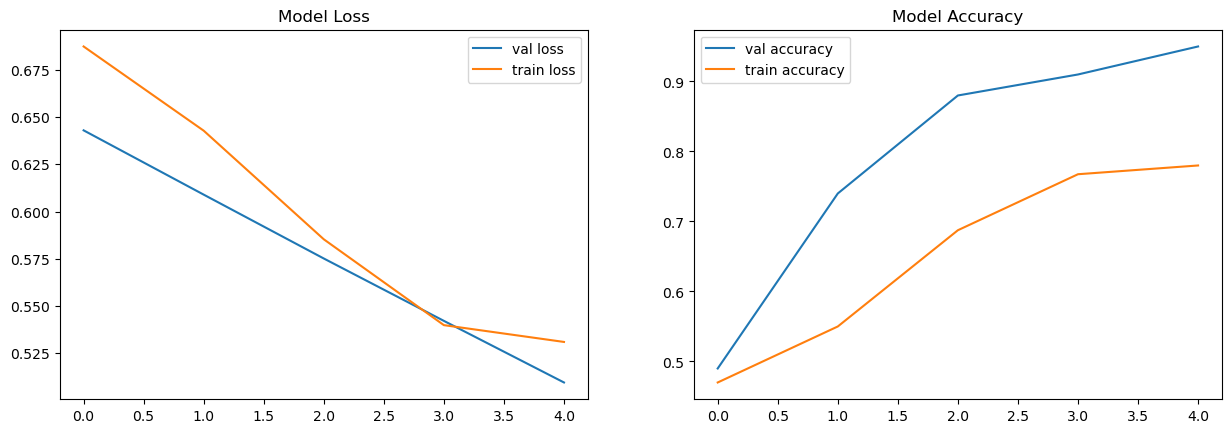

In [58]:
plot_history(history)

4/4 [==============================] - 0s 2ms/step


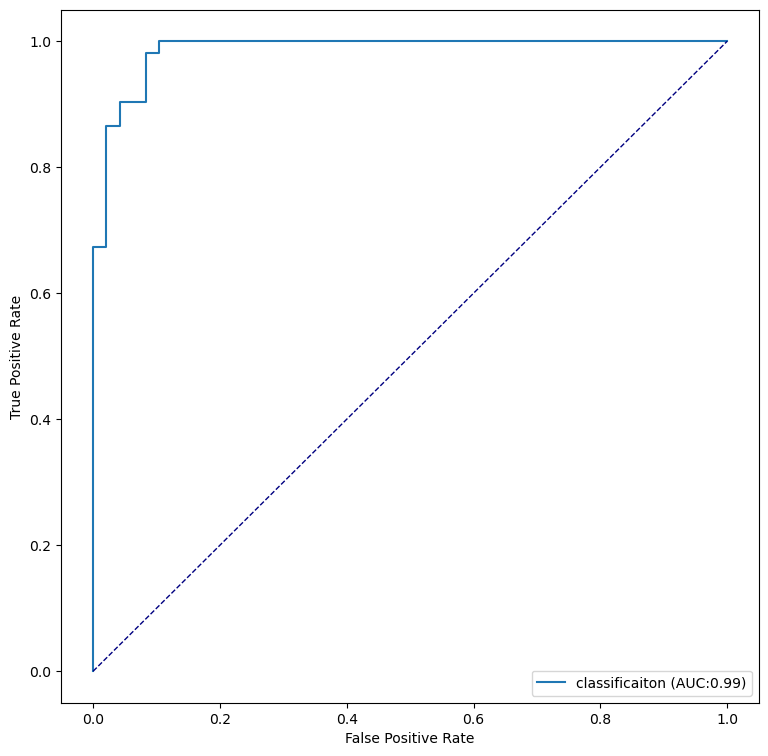

In [59]:
plot_roc(y_test, model.predict(x_test,verbose=True))

4/4 [==============================] - 0s 2ms/step


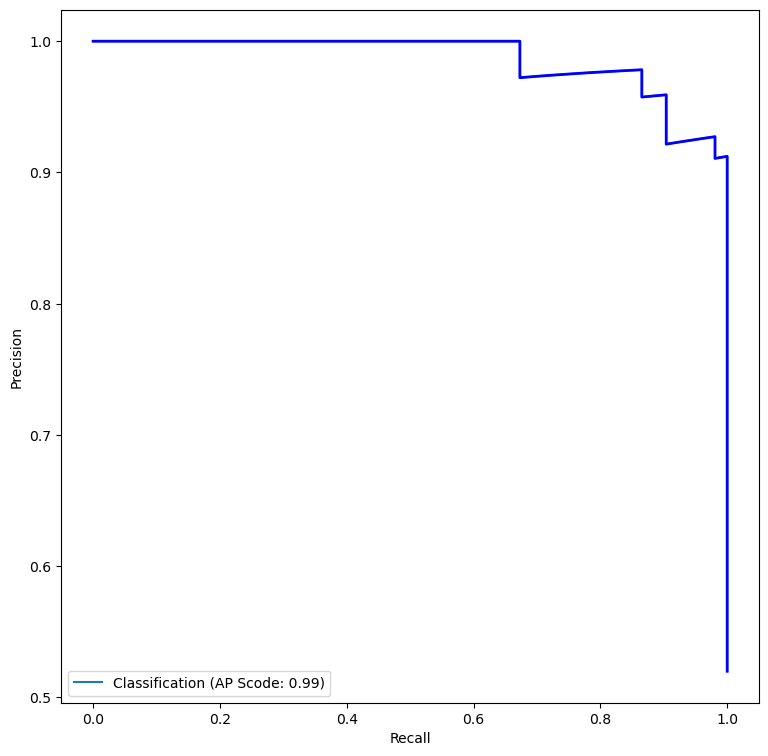

In [60]:
plot_precision_recall_curve_helper(y_test, model.predict(x_test,verbose=True))

In [62]:
# Threshold that optimizes model performance

def calculate_f1(precision, recall):
    return 2*(precision*recall)/(precision+recall) if recall and precision else 0

precision, recall, thresholds = precision_recall_curve(y_test, model.predict(x_test, verbose=True))
f1_score = [calculate_f1(precision[i],recall[i]) for i in range(len(thresholds))]
idx = np.argmax(f1_score)
threshold = thresholds[idx]

print("Precision: " + str(precision[idx]))
print("Recall: " + str(recall[idx]))
print("Threshold: " + str(threshold))
print("F1 Score: " + str(f1_score[idx]))


4/4 [==============================] - 0s 2ms/step
Precision: 0.9122807017543859
Recall: 1.0
Threshold: 0.49275228
F1 Score: 0.9541284403669724


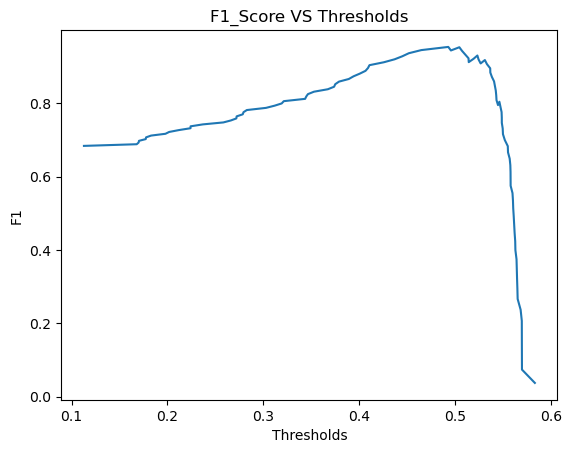

In [63]:
plt.figure()
plt.plot(thresholds,f1_score)
plt.title('F1_Score VS Thresholds')
plt.xlabel("Thresholds")
plt.ylabel("F1")
plt.show()